In [53]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error
import itertools
import matplotlib.pyplot as plt
import seaborn as sns


## Obtain Valid Joint Distribtutions

In [54]:
def solve_joint_distribution_iterate(pa, pb, num=50):
    
    """
    Iterates over all possible values of c and k within their ranges
    to solve the joint probability distribution.

    Parameters:
        pa: dict
            Marginal probabilities
        pb: dict
            Marginal probabilities 
        num: float
            number of points for iterating over c and k.

    Returns:
        list: A list of valid joint distributions that satisfy all constraints.
    """
    # Extract marginal probabilities
    pa00, pa10, pa01, pa11 = pa[(0, 0)], pa[(1, 0)], pa[(0, 1)], pa[(1, 1)]
    pb00, pb10, pb01, pb11 = pb[(0, 0)], pb[(1, 0)], pb[(0, 1)], pb[(1, 1)]
    
    # Bounds for c
    lower_bound_c = max(0, pb00 - pa10)
    upper_bound_c = min(1, pa00, pb00)
    
    # Bounds for k
    lower_bound_k = max(0, pb10 - pa11)
    upper_bound_k = min(1, pa01, pb10)

    # List to store valid joint distributions
    valid_joint_distributions = []
    
    # Iterate over all possible values of c and k
    c_values = np.linspace(lower_bound_c, upper_bound_c, num)
    k_values =  np.linspace(lower_bound_k, upper_bound_k, num)
    
    for c in c_values:
        for k in k_values:
            try:
                # Compute joint probabilities
                p000 = c
                p001 = pa00 - c
                p100 = pb00 - c
                p101 = pa10 - pb00 + c
                p010 = k
                p011 = pa01 - k
                p110 = pb10 - k
                p111 = pa11 - pb10 + k

                joint_distribution = {
                    "p000": p000, "p001": p001, "p100": p100, "p101": p101,
                    "p010": p010, "p011": p011, "p110": p110, "p111": p111
                }
                
                # Ensure all probabilities are positive and not zero
                #if any(value <= 0.01 for value in joint_distribution.values()):
                #    continue  # Skip this combination if any probability is <= 0
                
                # Ensure all constraints are met
                total_sum = sum(joint_distribution.values())
                all_positive = all(value >= 0 for value in joint_distribution.values())
                
                # Marginal constraints
                pa_computed = {
                    (0, 0): p000 + p001,
                    (1, 0): p100 + p101,
                    (0, 1): p010 + p011,
                    (1, 1): p110 + p111,
                }
                pb_computed = {
                    (0, 0): p000 + p100,
                    (1, 0): p001 + p101,
                    (0, 1): p010 + p110,
                    (1, 1): p011 + p111,
                }
                pa_valid = all(abs(pa[key] - pa_computed[key]) < 1e-9 for key in pa)
                pb_valid = all(abs(pb[key] - pb_computed[key]) < 1e-9 for key in pb)
                
                # If all conditions are satisfied, add to the list
                if abs(total_sum - 1) < 1e-9 and all_positive and pa_valid and pb_valid:
                    valid_joint_distributions.append(joint_distribution)
            
            except AssertionError:
                # Ignore invalid combinations
                continue
    
    return valid_joint_distributions

## Sample from Marginal and Joint Distribtions

In [55]:
np.random.seed(42)

def sample_data_from_distribution(joint_distribution, n_samples=1000):
    """
    Samples data points from a given joint probability distribution.

    Parameters:
        joint_distribution: dict
            A joint distribution dictionary.
        n_samples: int
            Number of data points to sample.

    Returns:
        pd.DataFrame: A DataFrame with columns X1, X2, X3.
    """
    # Extract probabilities and outcomes
    outcomes = [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1),
                (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
    probabilities = [joint_distribution[f"p{''.join(map(str, outcome))}"] for outcome in outcomes]
    
    # Sample indices based on probabilities
    sampled_indices = np.random.choice(len(outcomes), size=n_samples, p=probabilities)
    
    # Create the dataset
    data = np.array([outcomes[i] for i in sampled_indices])
    return pd.DataFrame(data, columns=["X1", "X2", "X3"])

def sample_data_from_marginal(distribution, n_samples=1000):
    """
    Samples data points from a given joint probability distribution.

    Parameters:
        joint_distribution: dict
            A joint distribution dictionary.
        n_samples: int
            Number of data points to sample.

    Returns:
        pd.DataFrame: A DataFrame with columns X1, X2, X3.
    """
    # Extract probabilities and outcomes
    outcomes = [(0, 0), (0, 1), (1, 0), (1, 1)]
    probabilities = [distribution[outcome] for outcome in outcomes]

    #probabilities = [distribution[f"p{''.join(map(str, outcome))}"] for outcome in outcomes]
    
    # Sample indices based on probabilities
    sampled_indices = np.random.choice(len(outcomes), size=n_samples, p=probabilities)
    
    # Create the dataset
    data = np.array([outcomes[i] for i in sampled_indices])
    return pd.DataFrame(data, columns=["X2", "X3"])



## Calculate Fairness Metrics

In [56]:
def calculate_fairness_metrics(y_true, y_pred, protected_attr):
    """
    Calculates fairness metrics based on predictions and the protected attribute.

    Parameters:
        y_true: array-like
            Ground truth labels.
        y_pred: array-like
            Predicted labels.
        protected_attr: array-like
            Protected attribute values.

    Returns:
        dict: Fairness metrics.
    """
    # Convert to arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    protected_attr = np.array(protected_attr)
    
    # Initialize metrics
    metrics = {
        "disparate_impact": {},
        "equal_opportunity": {}}
    
        # Create group masks
    group_mask_0 = protected_attr == 0
    group_mask_1 = protected_attr == 1

    # Check for empty groups
   # if np.sum(group_mask_0) == 0 or np.sum(group_mask_1) == 0:
    #    raise ValueError("One of the groups has no samples.")

    # Calculate disparate impact
    mean_0 = np.mean(y_pred[group_mask_0]) if np.any(group_mask_0) else 0
    mean_1 = np.mean(y_pred[group_mask_1]) if np.any(group_mask_1) else 0
    
    # Disparate Impact (mean_0 / mean_1), ensure no division by zero
    if mean_1 == 0:
        metrics["disparate_impact"] = np.nan  # or np.nan or a specific value (e.g., 0)
    else:
        metrics["disparate_impact"] = (mean_0 / mean_1)
        
        
    # True Positives and False Negatives for Group 0
    tp_group_0 = np.sum((y_pred[group_mask_0] == 1) & (y_true[group_mask_0] == 1))
    fn_group_0 = np.sum((y_pred[group_mask_0] == 0) & (y_true[group_mask_0] == 1))

    # True Positives and False Negatives for Group 1
    tp_group_1 = np.sum((y_pred[group_mask_1] == 1) & (y_true[group_mask_1] == 1))
    fn_group_1 = np.sum((y_pred[group_mask_1] == 0) & (y_true[group_mask_1] == 1))

    # TPR for each group
    tpr_group_0 = tp_group_0 / (tp_group_0 + fn_group_0) if (tp_group_0 + fn_group_0) > 0 else np.nan
    tpr_group_1 = tp_group_1 / (tp_group_1 + fn_group_1) if (tp_group_1 + fn_group_1) > 0 else np.nan

    # Equal Opportunity Difference
    metrics["equal_opportunity"] = tpr_group_0 - tpr_group_1
    
    return metrics

def regression_fairness_pipeline(data, model_type):
    
    """
    Full pipeline to sample data, fit regression models, and calculate fairness metrics.

    Parameters:
        valid_distributions: list
            List of valid joint distributions.
        n_samples: int
            Number of data points per dataset.

    Returns:
        list: Fairness metrics for each joint distribution.
    """    
    # Step 2: Train regression model
    X = data[["X2"]]
    y = data["X3"]
    model = model_type
    model.fit(X, y)
    
    return model


def obtain_fairness_metrics(model, joint_data):
        
    X = joint_data[['X2']]
    y = joint_data["X3"]
        
    y_pred = model.predict(X)
        
    # Step 3: Calculate fairness metrics
    fairness_metrics = calculate_fairness_metrics(y, y_pred, joint_data["X1"])
    
    return fairness_metrics


### Generate Valid Pairs of Marginals

In [57]:
from itertools import product

# Define the number of binary states for x1, x2, x3
num_states = 2

# Generate all possible valid values for a 2x2 joint distribution
def generate_all_p_a(range = np.arange(0.1, 0.9, 0.1)):
    p_a_list = []
    # Loop over all possible values for p_a(x1=0, x2=0), p_a(x1=0, x2=1), p_a(x1=1, x2=0)
    for p00, p01, p10 in product(range, repeat=3):
        p11 = 1 - (p00 + p01 + p10)  # Ensure the sum equals 1
        if p11 >= 0:  # Valid distribution if the last value is non-negative
            p_a = {
                (0, 0): p00,
                (1, 0): p10,
                (0, 1): p01,
                (1, 1): p11
            }
            p_a_list.append(p_a)
    return p_a_list

def generate_all_p_b(range = np.arange(0.1, 0.9, 0.1)):
    p_b_list = []
    # Loop over all possible values for p_b(x2=0, x3=0), p_b(x2=0, x3=1), p_b(x2=1, x3=0)
    for p00, p01, p10 in product(range, repeat=3):
        p11 = 1 - (p00 + p01 + p10)  # Ensure the sum equals 1
        if p11 >= 0:  # Valid distribution if the last value is non-negative
            p_b = {
                (0, 0): p00,
                (1, 0): p10,
                (0, 1): p01,
                (1, 1): p11
            }
            p_b_list.append(p_b)
    return p_b_list

# Check for marginal consistency over x2
def check_marginal_consistency(p_a, p_b):
 # Marginalize p_a over x1 to get p_a(x2)
    p_a_marginal = {x2: sum(p_a[(x1, x2)] for x1 in range(num_states)) for x2 in range(num_states)}
    
    # Marginalize p_b over x3 to get p_b(x2)
    p_b_marginal = {x2: sum(p_b[(x2, x3)] for x3 in range(num_states)) for x2 in range(num_states)}
    
    # Check if the marginals over x2 are consistent
    return np.allclose(list(p_a_marginal.values()), list(p_b_marginal.values()))


In [99]:
def generate_all_distributions(p_a_range = np.arange(0.1, 0.9, 0.1), p_b_range = np.arange(0.1, 0.9, 0.1), 
                               n_samples=100, classifier=DecisionTreeClassifier(), num_joint=50):
    """
    Generate all valid joint distributions, train models, and compute fairness metrics.
    
    Parameters:
        p_a_list (list): List of marginal probabilities for group A.
        p_b_list (list): List of marginal probabilities for group B.
        n_samples (int): Number of samples to draw for each distribution.
        classifier: ML model to use for fairness pipeline.
        num_joint (int): Number of joint distributions to generate.
    
    Returns:
        pd.DataFrame: DataFrame containing results for each valid distribution.
    """
    
    p_a_list = generate_all_p_a(p_a_range)
    p_b_list = generate_all_p_b(p_b_range)

    # Dictionary to store all valid distributions for each (p_a, p_b)
    data = []
    
    for p_a in p_a_list:
        for p_b in p_b_list:
            if check_marginal_consistency(p_a, p_b):
                
                # Sample training data and train model
                train_data_sample = sample_data_from_marginal(p_b, n_samples=n_samples)
                model = regression_fairness_pipeline(train_data_sample, classifier)
                
                # Generate joint distributions
                joint_dist = solve_joint_distribution_iterate(p_a, p_b, num=num_joint)
                
                for joint in joint_dist:
                    # Repeatedly sample from the joint distribution and calculate fairness metrics
                    disparate_impact_values = []
                    equal_opportunity_values = []
                    
                    for _ in range(50):
                        # Sample from joint distribution
                        joint_data_sample = sample_data_from_distribution(joint, n_samples=n_samples)
                        
                        # Obtain fairness metrics
                        metrics = obtain_fairness_metrics(model, joint_data_sample)
                        disparate_impact_values.append(metrics['disparate_impact'])
                        equal_opportunity_values.append(metrics['equal_opportunity'])
                    
                    # Compute mean of fairness metrics
                    mean_disparate_impact = np.mean(disparate_impact_values)
                    mean_equal_opportunity = np.mean(equal_opportunity_values)
                    
                    # Append results to data
                    data.append({
                        'p_a': p_a,
                        'p_b': p_b,
                        'joint_distribution': joint,
                        'mean_disparate_impact': mean_disparate_impact,
                        'mean_equal_opportunity': mean_equal_opportunity
                    })
    
    # Convert to DataFrame
    return pd.DataFrame(data)

In [101]:
df = generate_all_distributions(p_a_range = np.arange(0.1, 0.9, 0.1), p_b_range = np.arange(0.1, 0.9, 0.1), 
                               n_samples=100, classifier=DecisionTreeClassifier(), num_joint=50)

In [102]:
print(df)

                                                      p_a  \
0       {(0, 0): 0.1, (1, 0): 0.1, (0, 1): 0.1, (1, 1)...   
1       {(0, 0): 0.1, (1, 0): 0.1, (0, 1): 0.1, (1, 1)...   
2       {(0, 0): 0.1, (1, 0): 0.1, (0, 1): 0.1, (1, 1)...   
3       {(0, 0): 0.1, (1, 0): 0.1, (0, 1): 0.1, (1, 1)...   
4       {(0, 0): 0.1, (1, 0): 0.1, (0, 1): 0.1, (1, 1)...   
...                                                   ...   
759995  {(0, 0): 0.8, (1, 0): 0.1, (0, 1): 0.1, (1, 1)...   
759996  {(0, 0): 0.8, (1, 0): 0.1, (0, 1): 0.1, (1, 1)...   
759997  {(0, 0): 0.8, (1, 0): 0.1, (0, 1): 0.1, (1, 1)...   
759998  {(0, 0): 0.8, (1, 0): 0.1, (0, 1): 0.1, (1, 1)...   
759999  {(0, 0): 0.8, (1, 0): 0.1, (0, 1): 0.1, (1, 1)...   

                                                      p_b  \
0       {(0, 0): 0.1, (1, 0): 0.1, (0, 1): 0.1, (1, 1)...   
1       {(0, 0): 0.1, (1, 0): 0.1, (0, 1): 0.1, (1, 1)...   
2       {(0, 0): 0.1, (1, 0): 0.1, (0, 1): 0.1, (1, 1)...   
3       {(0, 0): 0.1, (

In [103]:
# Function to flatten dictionary column into separate columns
def flatten_dict_column(df, column_name):
    """
    This function flattens a dictionary column in a DataFrame into individual columns.
    Each key of the dictionary becomes a column in the DataFrame.
    """
    # Normalize the dictionary column into individual columns
    dict_data = pd.json_normalize(df[column_name])
    
    # Rename columns to match the format of the dictionary keys
    dict_data.columns = [f"{column_name}_{str(key)}" for key in dict_data.columns]
    
    return dict_data

# Flatten the 'p_a', 'p_b', and 'joint_distribution' columns
flattened_p_a = flatten_dict_column(df, 'p_a')
flattened_p_b = flatten_dict_column(df, 'p_b')
flattened_joint = flatten_dict_column(df, 'joint_distribution')

# Step 2: Concatenate the flattened columns with the original DataFrame
df_final = pd.concat([df.drop(['p_a', 'p_b', 'joint_distribution'], axis=1), flattened_p_a, flattened_p_b, flattened_joint], axis=1)

df_final.dropna(inplace=True, ignore_index=True)

print(df_final)

        mean_disparate_impact  mean_equal_opportunity  p_a_(0, 0)  p_a_(1, 0)  \
0                    1.000000                0.000000         0.1         0.1   
1                    1.000000                0.000000         0.1         0.1   
2                    1.000000                0.000000         0.1         0.1   
3                    1.000000                0.000000         0.1         0.1   
4                    1.000000                0.000000         0.1         0.1   
...                       ...                     ...         ...         ...   
482309               0.542234                0.537350         0.6         0.1   
482310               0.518553                0.509156         0.6         0.1   
482311               0.552935                0.513465         0.6         0.1   
482312               0.536933                0.508840         0.6         0.1   
482313               0.593179                0.520112         0.6         0.1   

        p_a_(0, 1)  p_a_(1,

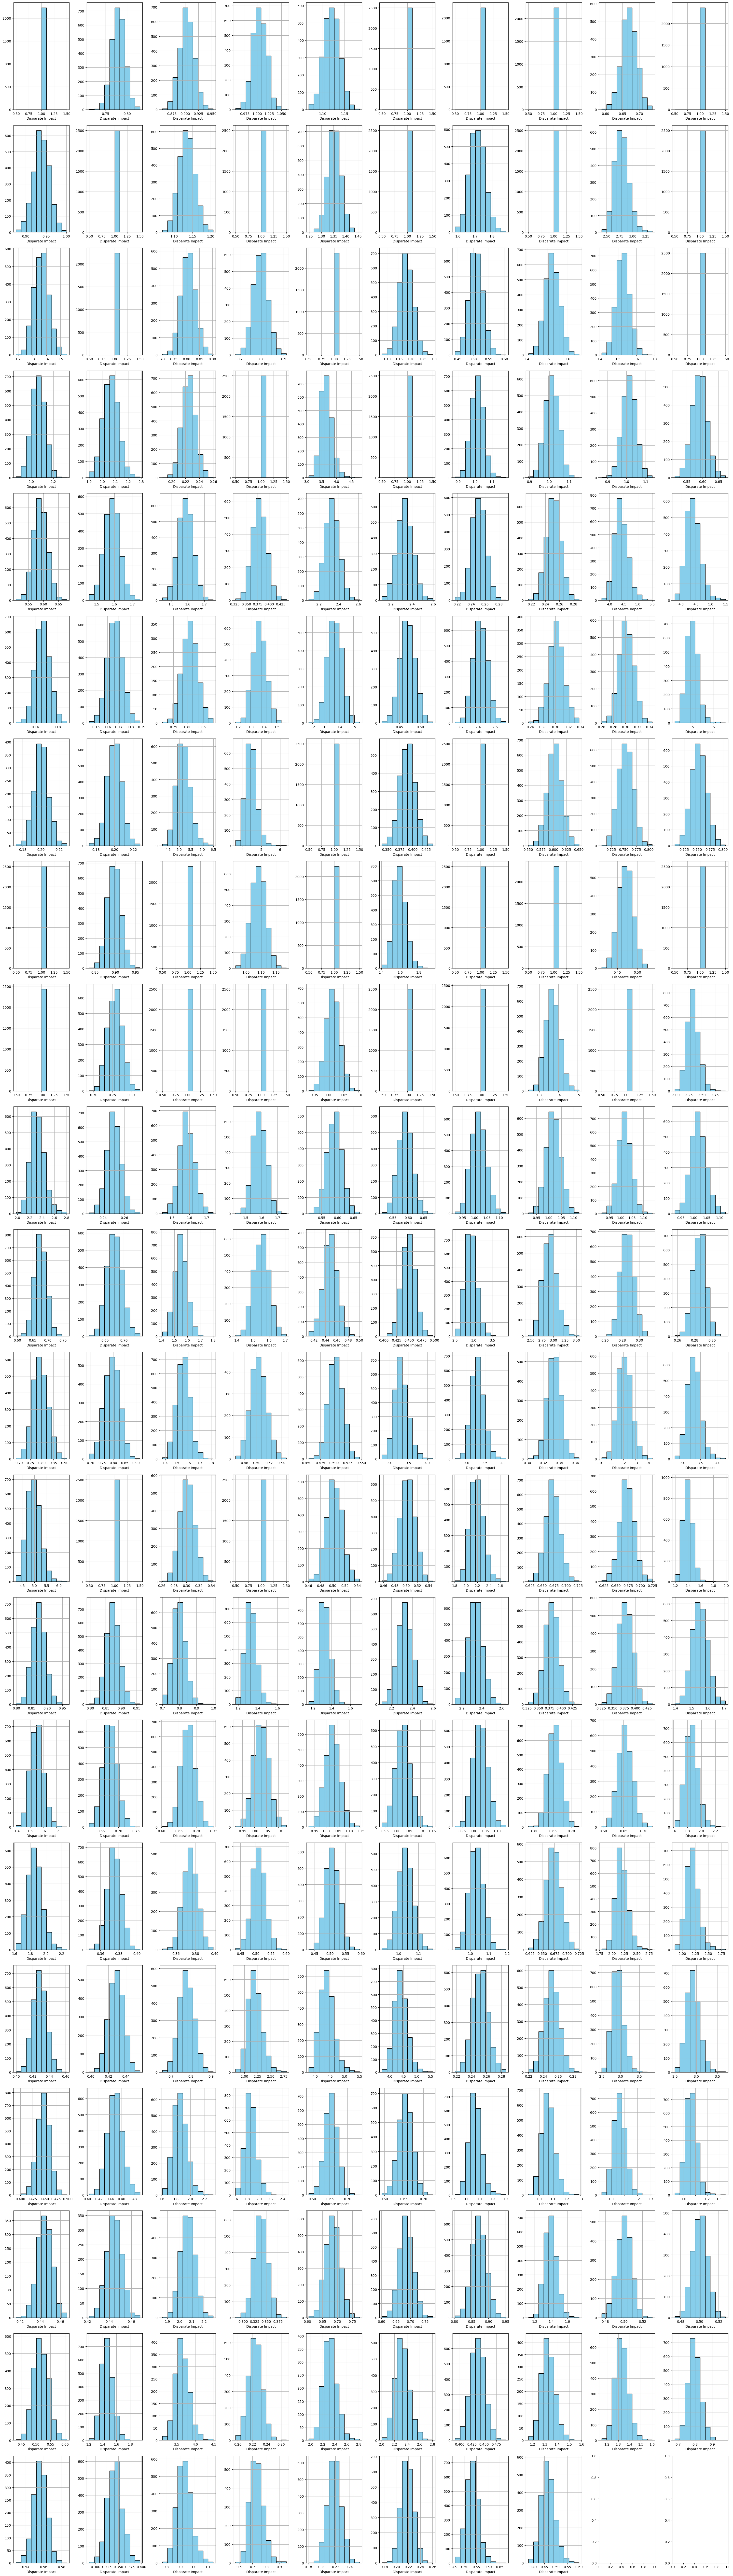

In [104]:
p_a_b_columns = [col for col in df_final.columns if col.startswith('p_a') or col.startswith('p_b')]

# Group by the selected columns
grouped_df = df_final.groupby(p_a_b_columns)['mean_disparate_impact'].apply(list).reset_index()

# Number of subplots (one for each group)
num_groups = len(grouped_df)

# Set up the subplots
cols = 10  # Number of columns of subplots
rows = (num_groups // cols) + (num_groups % cols > 0)  # Calculate number of rows required

fig, axes = plt.subplots(rows, cols, figsize=(30, 5 * rows))
axes = axes.flatten()  # Flatten the axes to make it easier to index

# Loop through the groups and plot the histograms
for idx, (row, ax) in enumerate(zip(grouped_df.iterrows(), axes)):
    # Unpack group data
    _, row_data = row
    group_label = f"p_a: {row_data['p_a_(0, 0)'], row_data['p_a_(1, 0)'], row_data['p_a_(0, 1)'], row_data['p_a_(1, 1)']} | " \
                  f"p_b: {row_data['p_b_(0, 0)'], row_data['p_b_(1, 0)'], row_data['p_b_(0, 1)'], row_data['p_b_(1, 1)']}"
    
    # Plot the histogram in the correct subplot
    ax.hist(row_data['mean_disparate_impact'], bins=10, edgecolor='black', color='skyblue')
    #ax.set_title(f"Histogram of Disparate Impact for Group: {group_label}")
    ax.set_xlabel('Disparate Impact')
    #ax.set_ylabel('Frequency')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [105]:
# Initialize accumulators
total_min = 0
total_max = 0
total_range = 0
num_groups = len(grouped_df)

# Loop through groups to calculate min, max, and range
for idx, row in grouped_df.iterrows():
    di_min = min(row['mean_disparate_impact'])
    di_max = max(row['mean_disparate_impact'])
    di_range = di_max - di_min
    
    # Accumulate values
    total_min += di_min
    total_max += di_max
    total_range += di_range

# Compute averages
avg_min = total_min / num_groups
avg_max = total_max / num_groups
avg_range = total_range / num_groups

# Print the results
print(f"Average Minimum Disparate Impact: {avg_min:.4f}")
print(f"Average Maximum Disparate Impact: {avg_max:.4f}")
print(f"Average Range of Disparate Impact: {avg_range:.4f}")

Average Minimum Disparate Impact: 1.0819
Average Maximum Disparate Impact: 1.4235
Average Range of Disparate Impact: 0.3417


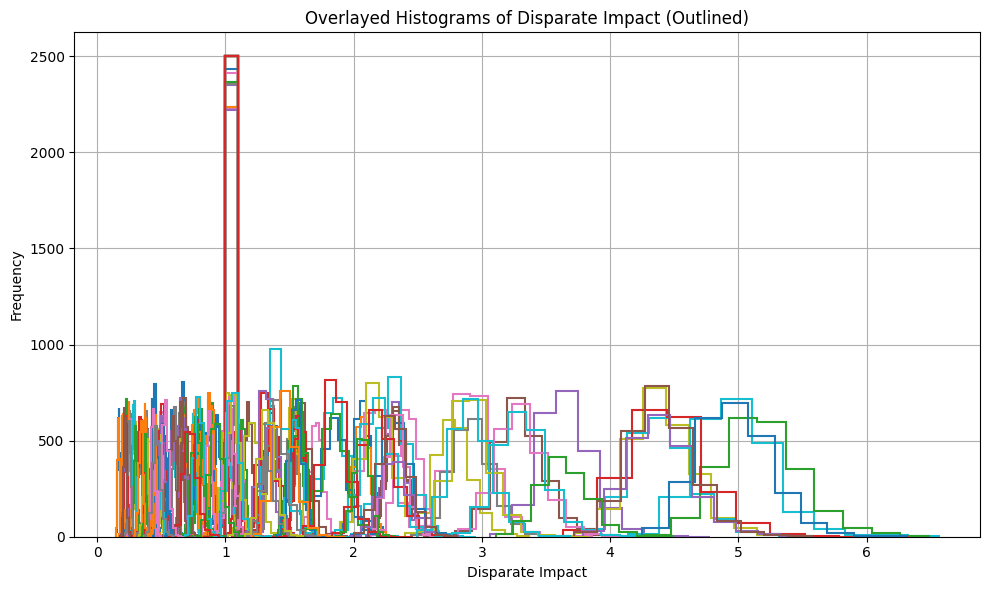

In [106]:
# Set up the figure
plt.figure(figsize=(10, 6))

# Loop through the groups and plot the histograms as outlines
for idx, row in grouped_df.iterrows():
    group_label = f"p_a: {row['p_a_(0, 0)'], row['p_a_(1, 0)'], row['p_a_(0, 1)'], row['p_a_(1, 1)']} | " \
                  f"p_b: {row['p_b_(0, 0)'], row['p_b_(1, 0)'], row['p_b_(0, 1)'], row['p_b_(1, 1)']}"
    
    # Plot the histogram outline for this group
    plt.hist(row['mean_disparate_impact'], bins=10, histtype='step', linewidth=1.5)

# Add titles and labels
plt.title('Overlayed Histograms of Disparate Impact (Outlined)')
plt.xlabel('Disparate Impact')
plt.ylabel('Frequency')
#plt.legend(loc='upper right', fontsize='small')  # Add legend for group labels
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

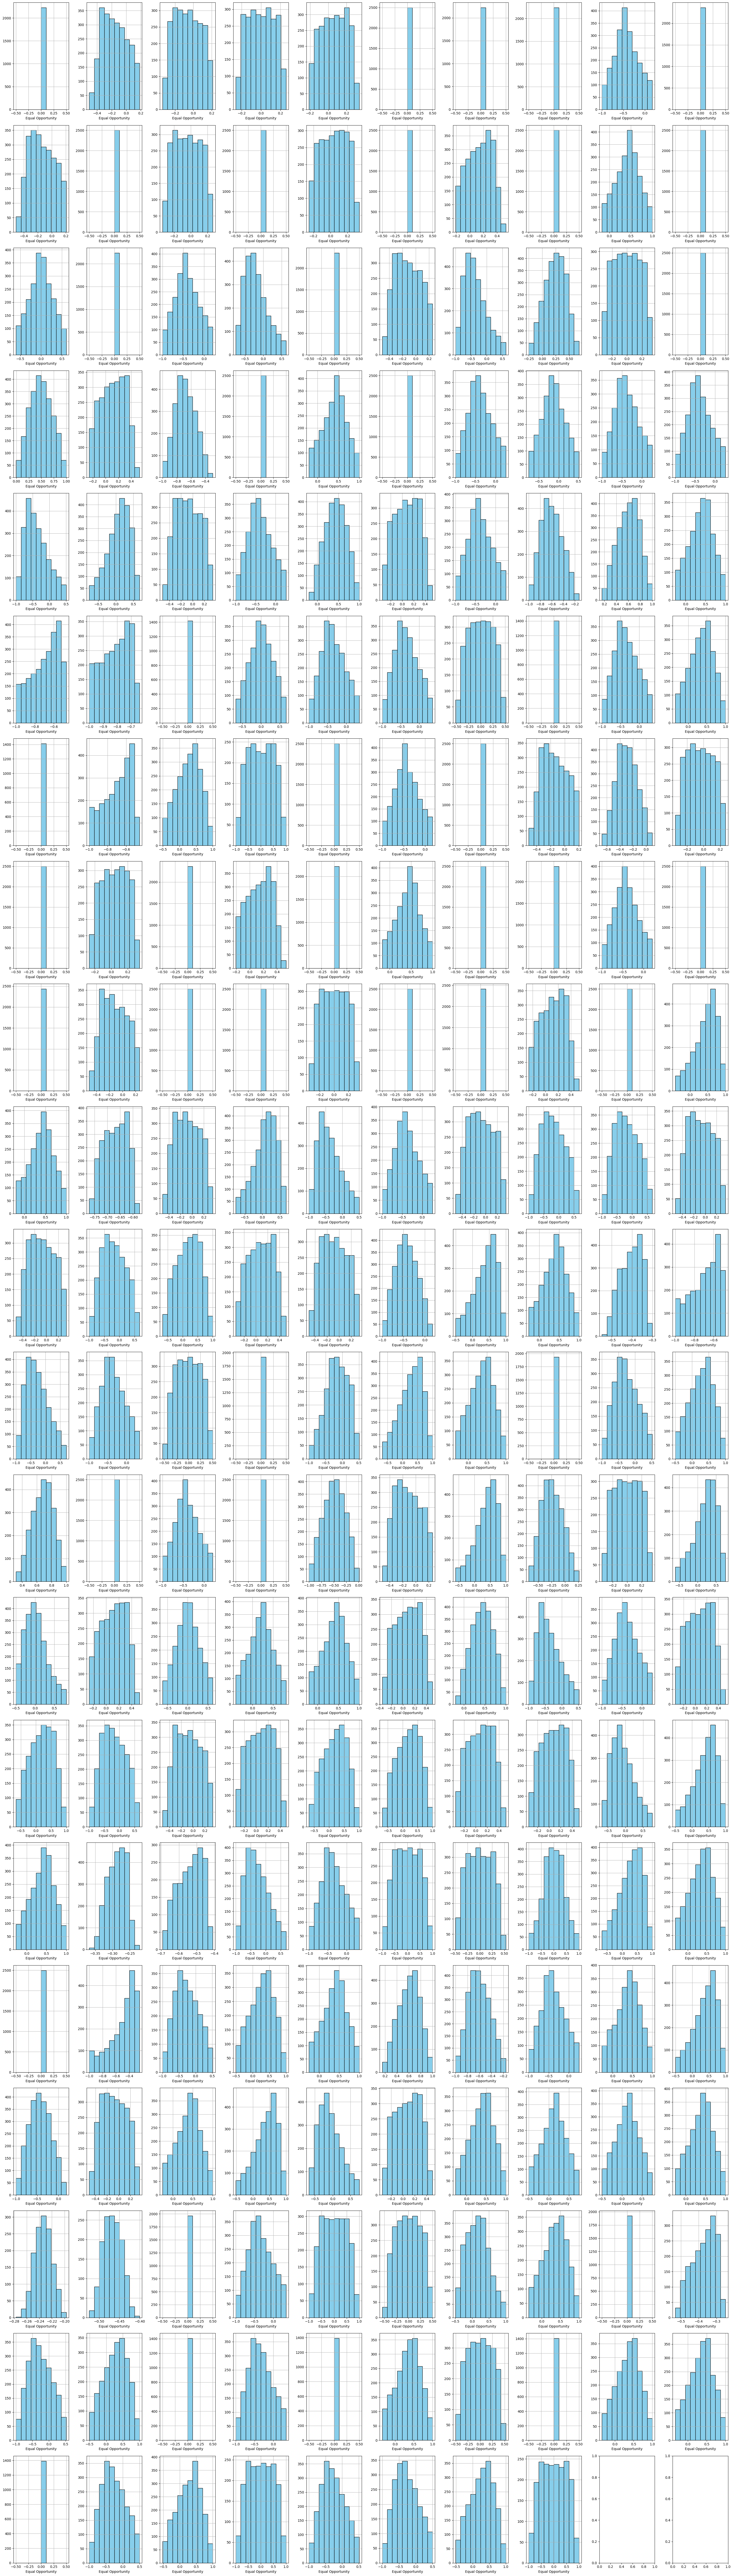

In [107]:
p_a_b_columns = [col for col in df_final.columns if col.startswith('p_a') or col.startswith('p_b')]

# Group by the selected columns
grouped_df = df_final.groupby(p_a_b_columns)['mean_equal_opportunity'].apply(list).reset_index()

# Number of subplots (one for each group)
num_groups = len(grouped_df)

# Set up the subplots
cols = 10  # Number of columns of subplots
rows = (num_groups // cols) + (num_groups % cols > 0)  # Calculate number of rows required

fig, axes = plt.subplots(rows, cols, figsize=(30, 5 * rows))
axes = axes.flatten()  # Flatten the axes to make it easier to index

# Loop through the groups and plot the histograms
for idx, (row, ax) in enumerate(zip(grouped_df.iterrows(), axes)):
    # Unpack group data
    _, row_data = row
    group_label = f"p_a: {row_data['p_a_(0, 0)'], row_data['p_a_(1, 0)'], row_data['p_a_(0, 1)'], row_data['p_a_(1, 1)']} | " \
                  f"p_b: {row_data['p_b_(0, 0)'], row_data['p_b_(1, 0)'], row_data['p_b_(0, 1)'], row_data['p_b_(1, 1)']}"
    
    # Plot the histogram in the correct subplot
    ax.hist(row_data['mean_equal_opportunity'], bins=10, edgecolor='black', color='skyblue')
    #ax.set_title(f"Histogram of Disparate Impact for Group: {group_label}")
    ax.set_xlabel('Equal Opportunity')
    #ax.set_ylabel('Frequency')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

In [108]:
# Initialize accumulators
total_min = 0
total_max = 0
total_range = 0
num_groups = len(grouped_df)

# Loop through groups to calculate min, max, and range
for idx, row in grouped_df.iterrows():
    di_min = min(row['mean_equal_opportunity'])
    di_max = max(row['mean_equal_opportunity'])
    di_range = di_max - di_min
    
    # Accumulate values
    total_min += di_min
    total_max += di_max
    total_range += di_range

# Compute averages
avg_min = total_min / num_groups
avg_max = total_max / num_groups
avg_range = total_range / num_groups

# Print the results
print(f"Average Minimum Equal Opportunity: {avg_min:.4f}")
print(f"Average Maximum Equal Opportunity: {avg_max:.4f}")
print(f"Average Range of Equal Opportunity: {avg_range:.4f}") 

Average Minimum Equal Opportunity: -0.4846
Average Maximum Equal Opportunity: 0.4262
Average Range of Equal Opportunity: 0.9109


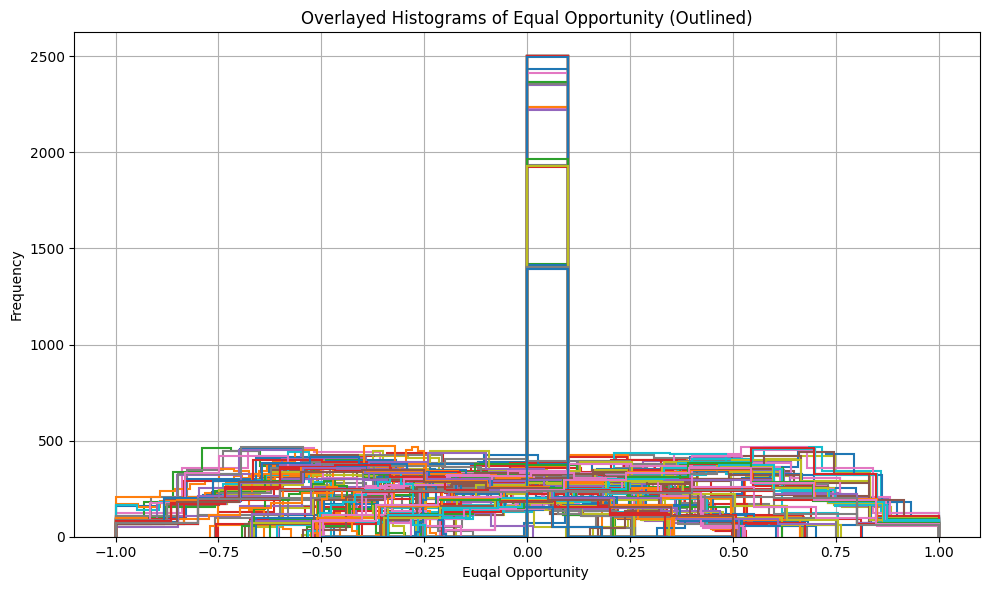

In [109]:
# Set up the figure
plt.figure(figsize=(10, 6))

# Loop through the groups and plot the histograms as outlines
for idx, row in grouped_df.iterrows():
    group_label = f"p_a: {row['p_a_(0, 0)'], row['p_a_(1, 0)'], row['p_a_(0, 1)'], row['p_a_(1, 1)']} | " \
                  f"p_b: {row['p_b_(0, 0)'], row['p_b_(1, 0)'], row['p_b_(0, 1)'], row['p_b_(1, 1)']}"
    
    # Plot the histogram outline for this group
    plt.hist(row['mean_equal_opportunity'], bins=10, histtype='step', linewidth=1.5)

# Add titles and labels
plt.title('Overlayed Histograms of Equal Opportunity (Outlined)')
plt.xlabel('Euqal Opportunity ')
plt.ylabel('Frequency')
#plt.legend(loc='upper right', fontsize='small')  # Add legend for group labels
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [110]:
df_final.to_csv('output_full.csv', index=False)  # Saves the DataFrame to a CSV file without the index

KeyError: 'disparate_impact'

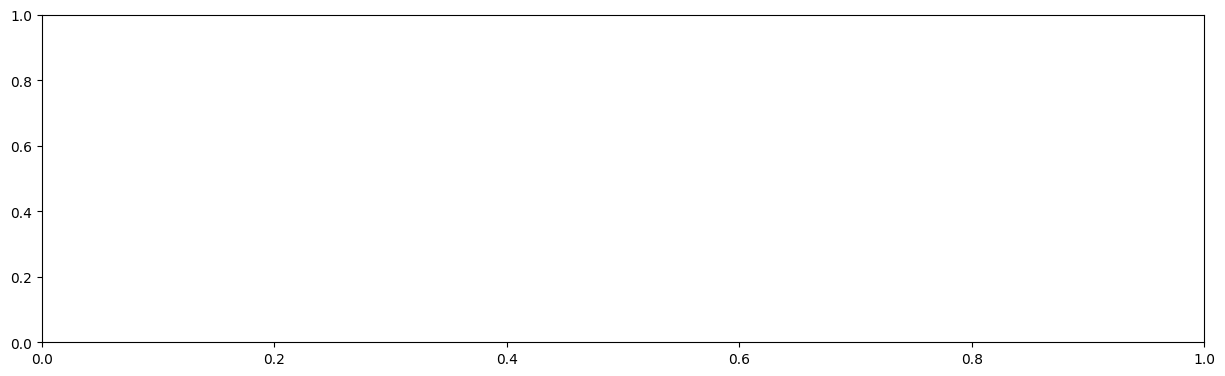

In [93]:
# Identify joint distribution columns
joint_distribution_columns = [col for col in df_final.columns if col.startswith('joint_distribution')]

# Set up the figure
plt.figure(figsize=(15, 5 * len(joint_distribution_columns)))

# Loop through each joint distribution column and plot against disparate_impact
for idx, column in enumerate(joint_distribution_columns, 1):
    plt.subplot(len(joint_distribution_columns), 1, idx)
    plt.scatter(df_final[column], df_final['disparate_impact'], alpha=0.7, edgecolor='black')
    plt.title(f'Disparate Impact vs. {column}')
    plt.xlabel(column)
    plt.ylabel('Disparate Impact')
    plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Identify joint distribution columns
joint_distribution_columns = [col for col in df_final.columns if col.startswith('joint_distribution')]

# Set up the figure
plt.figure(figsize=(15, 5 * len(joint_distribution_columns)))

# Loop through each joint distribution column and plot against disparate_impact
for idx, column in enumerate(joint_distribution_columns, 1):
    plt.subplot(len(joint_distribution_columns), 1, idx)
    plt.scatter(df_final[column], df_final['equal_opportunity'], alpha=0.7, edgecolor='black')
    plt.title(f'Equal Opp vs. {column}')
    plt.xlabel(column)
    plt.ylabel('Equal Opp')
    plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [111]:
# Calculate P(x_3 = 1 | x_1 = 0) for each row based on the joint distribution columns
df_final['P(Y=1|A=0)'] = (
    df_final['joint_distribution_p001'] + df_final['joint_distribution_p011']) / (
    df_final['joint_distribution_p000'] + df_final['joint_distribution_p001'] + 
    df_final['joint_distribution_p010'] + df_final['joint_distribution_p011'] 
)

# Check the new column
print(df_final[['P(Y=1|A=0)']].head())

# Calculate P(x_3 = 1 | x_1 = 0) for each row based on the joint distribution columns
df_final['P(Y=1|A=1)'] = (
    df_final['joint_distribution_p101'] + df_final['joint_distribution_p111']) / (
    df_final['joint_distribution_p100'] + df_final['joint_distribution_p101'] + 
    df_final['joint_distribution_p110'] + df_final['joint_distribution_p111'] 
)

# Check the new column
print(df_final[['P(Y=1|A=1)']].head())



   P(Y=1|A=0)
0    1.000000
1    0.989796
2    0.979592
3    0.969388
4    0.959184
   P(Y=1|A=1)
0    0.750000
1    0.752551
2    0.755102
3    0.757653
4    0.760204


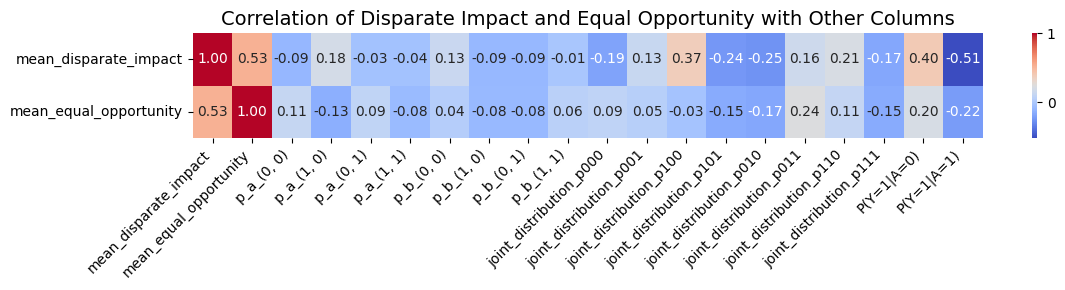

In [112]:

# Calculate the full correlation matrix
correlation_matrix = df_final.corr()

# Filter the matrix to include only `disparate_impact` and `equal_opportunity` as rows
filtered_correlation_matrix = correlation_matrix.loc[['mean_disparate_impact', 'mean_equal_opportunity'], :]

# Set up the figure
plt.figure(figsize=(12, 3))  # Adjust the height for better visualization

# Plot the heatmap
sns.heatmap(filtered_correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Add titles and labels
plt.title('Correlation of Disparate Impact and Equal Opportunity with Other Columns', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:

# Create a scatter plot of P_x3_given_x1_0 against disparate_impact
plt.figure(figsize=(10, 6))
plt.scatter(df_final['P(Y=1|A=0)'], df_final['disparate_impact'], color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('P(Y=1|A=0))')
plt.ylabel('Disparate Impact')
plt.title('Scatter Plot of P(Y=1|A=0) vs Disparate Impact')

# Show grid
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# Create a scatter plot of P_x3_given_x1_0 against disparate_impact
plt.figure(figsize=(10, 6))
plt.scatter(df_final['P(Y=1|A=0)'], df_final['equal_opportunity'], color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('P(Y=1|A=0)')
plt.ylabel('Disparate Impact')
plt.title('Scatter Plot of P(Y=1|A=0) vs Disparate Impact')

# Show grid
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# Example marginals
pa = {(0, 0): 0.3, (1, 0): 0.2, (0, 1): 0.1, (1, 1): 0.4}
pb = {(0, 0): 0.25, (1, 0): 0.1, (0, 1): 0.25, (1, 1): 0.4}

# Compute valid joint distributions
valid_distributions = solve_joint_distribution_iterate(p_a, p_b, num=50)

print(f"Found {len(valid_distributions)} valid distributions.")
for dist in valid_distributions[:5]:  # Display first 5 results
    print(dist)

In [ ]:
# compute fairness metrics
fairness_results = regression_fairness_pipeline(valid_distributions, n_samples=1000)

print(f"Fairness metrics for {len(fairness_results)} joint distributions:")
for idx, metrics in enumerate(fairness_results[:5]):  # Show first 5 results
    print(f"Distribution {idx + 1}: {metrics}")

In [ ]:
# Initialize a dictionary to collect all p* values
ps_values = {}

# Iterate over each dictionary in the data
for entry in valid_distributions:
    for key, value in entry.items():
        if key not in ps_values:
            ps_values[key] = []
        ps_values[key].append(float(value))  # Convert to standard float for clarity

# Print the organized dictionary
for key, values in ps_values.items():
    print(f"{key}: {values}")


In [ ]:

def calculate_conditional_probability(ps_values):
    """
    Calculate the conditional probability p(x3 = 1 | x1 = 0) from the given joint distribution `ps_values`.
    If the denominator is 0, return np.nan (Not a Number).
    
    Args:
    ps_values (dict): Dictionary containing joint distribution probabilities for each key.
    
    Returns:
    list: A list of conditional probabilities for each entry in `ps_values`.
    """
    
    # Calculate p(x3 = 1 and x1 = 0) -> sum of p001, p011, p101, p111 for each entry
    p_x3_1_and_x1_0_values = [
        ps_values['p001'][i] + ps_values['p011'][i] 
        for i in range(len(ps_values['p001']))
    ]
    
    # Calculate p(x1 = 0) -> sum of p000, p001, p010, p011 for each entry
    p_x1_0_values = [
        ps_values['p000'][i] + ps_values['p001'][i] + ps_values['p010'][i] + ps_values['p011'][i]
        for i in range(len(ps_values['p000']))
    ]
    
    # Calculate conditional probability p(x3 = 1 | x1 = 0) for each entry
    p_x3_1_given_x1_0_values = []
    
    for i in range(len(p_x1_0_values)):
        # Check for zero in the denominator
        if p_x1_0_values[i] == 0:
            p_x3_1_given_x1_0_values.append(np.nan)  # Return np.nan for undefined conditional probability
        else:
            p_x3_1_given_x1_0_values.append(p_x3_1_and_x1_0_values[i] / p_x1_0_values[i])
    
    return p_x3_1_given_x1_0_values


# Calculate conditional probabilities
conditional_probabilities = calculate_conditional_probability(ps_values)

print("p(x3 = 1 | x1 = 0) for each entry:", conditional_probabilities)


In [ ]:
import numpy as np

def calculate_conditional_probability(ps_values):
    """
    Calculate the conditional probabilities p(x3 = 1 | x1 = 0) and p(x3 = 1 | x1 = 1) 
    from the given joint distribution `ps_values`.
    If the denominator is 0, return np.nan (Not a Number).
    
    Args:
    ps_values (dict): Dictionary containing joint distribution probabilities for each key.
    
    Returns:
    dict: A dictionary with conditional probabilities for both x1 = 0 and x1 = 1.
    """
    
    # Calculate p(x3 = 1 and x1 = 0) -> sum of p001, p011, p101, p111 for each entry
    p_x3_1_and_x1_0_values = [
        ps_values['p001'][i] + ps_values['p011'][i]
        for i in range(len(ps_values['p001']))
    ]
    
    # Calculate p(x3 = 1 and x1 = 1) -> sum of p100, p101, p110, p111 for each entry
    p_x3_1_and_x1_1_values = [
        ps_values['p101'][i] + ps_values['p111'][i]
        for i in range(len(ps_values['p100']))
    ]
    
    # Calculate p(x1 = 0) -> sum of p000, p001, p010, p011 for each entry
    p_x1_0_values = [
        ps_values['p000'][i] + ps_values['p001'][i] + ps_values['p010'][i] + ps_values['p011'][i]
        for i in range(len(ps_values['p000']))
    ]
    
    # Calculate p(x1 = 1) -> sum of p100, p101, p110, p111 for each entry
    p_x1_1_values = [
        ps_values['p100'][i] + ps_values['p101'][i] + ps_values['p110'][i] + ps_values['p111'][i]
        for i in range(len(ps_values['p100']))
    ]
    
    # Calculate conditional probabilities p(x3 = 1 | x1 = 0) and p(x3 = 1 | x1 = 1)
    p_x3_1_given_x1_0_values = []
    p_x3_1_given_x1_1_values = []
    
    for i in range(len(p_x1_0_values)):
        # Check for zero in the denominators
        if p_x1_0_values[i] == 0:
            p_x3_1_given_x1_0_values.append(np.nan)  # Return np.nan for undefined conditional probability
        else:
            p_x3_1_given_x1_0_values.append(p_x3_1_and_x1_0_values[i] / p_x1_0_values[i])
        
        if p_x1_1_values[i] == 0:
            p_x3_1_given_x1_1_values.append(np.nan)  # Return np.nan for undefined conditional probability
        else:
            p_x3_1_given_x1_1_values.append(p_x3_1_and_x1_1_values[i] / p_x1_1_values[i])
    
    # Return a dictionary of the conditional probabilities
    return {
        'p_x3_1_given_x1_0': p_x3_1_given_x1_0_values,
        'p_x3_1_given_x1_1': p_x3_1_given_x1_1_values
    }


# Calculate conditional probabilities
conditional_probabilities = calculate_conditional_probability(ps_values)

print("p(x3 = 1 | x1 = 0) for each entry:", conditional_probabilities['p_x3_1_given_x1_0'])
print("p(x3 = 1 | x1 = 1) for each entry:", conditional_probabilities['p_x3_1_given_x1_1'])


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_fairness_metrics_distributions(fairness_results):
    """
    Plots the distributions of fairness metrics.

    Parameters:
        fairness_results: list
            List of fairness metrics for each joint distribution.
    """
    # Extract the fairness metrics for each distribution
    disparate_impact = [metrics["disparate_impact"] for metrics in fairness_results]
    equal_opportunity = [metrics["equal_opportunity"] for metrics in fairness_results]
    
    # Set up the plot
    plt.figure(figsize=(15, 5))
    
    # Plot Demographic Parity distribution
    plt.subplot(1, 3, 1)
    sns.histplot(disparate_impact, kde=True, color='skyblue')
    plt.title('Disparate Impact Distribution')
    plt.xlabel('Disparate Impact')
    plt.ylabel('Frequency')
    
    # Plot Equal Opportunity distribution
    plt.subplot(1, 3, 2)
    sns.histplot(equal_opportunity, kde=True, color='lightgreen')
    plt.title('Equal Opportunity Diff Distribution')
    plt.xlabel('Equal Opportunity')
    plt.ylabel('Frequency')
    
    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# Example usage
#valid_distributions = solve_joint_distribution_iterate(pa, pb, step=0.01)
#fairness_results = regression_fairness_pipeline(valid_distributions, n_samples=1000)

# Plot the distributions of fairness metrics
plot_fairness_metrics_distributions(fairness_results)


In [420]:
disparate_impact = [metrics["disparate_impact"] for metrics in fairness_results]
equal_opportunity = [metrics["equal_opportunity"] for metrics in fairness_results]

In [ ]:

# Create separate scatter plots for each p-variable
for p_key, values in ps_values.items():
    plt.figure(figsize=(10, 4))
    plt.scatter(disparate_impact, values, label=p_key)
    plt.xlabel('Disparate Impact')
    plt.ylabel(f'Values of {p_key}')
    plt.title(f'{p_key} vs. Disparate Impact')
    plt.xticks(np.arange(0,0.55, 0.05))  # Specify x-axis ticks
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
# Create separate scatter plots for each p-variable
for p_key, values in ps_values.items():
    plt.figure(figsize=(10, 4))
    plt.scatter(equal_opportunity, values, label=p_key)
    plt.xlabel('Disparate Impact')
    plt.ylabel(f'Values of {p_key}')
    plt.title(f'{p_key} vs. Disparate Impact')
    plt.xticks(np.arange(-1.0,0.2, 0.1))  # Specify x-axis ticks
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
# Create separate scatter plots for each p-variable
plt.figure(figsize=(6, 4))
plt.scatter(disparate_impact, conditional_probabilities, label=p_key)
plt.xlabel('Disparate Impact')
plt.ylabel(f'Values of p(x_3 = 1 | x_1  = 0)')
plt.title(f'{p_key} vs. Disparate Impact')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
for result in conditional_results[:5]:  # Display first 5 results
    print(f"P(X_3 = 1 | X_1 = 0): {result['p_x3_1_given_x1_0']}")
    print(f"P(X_3 = 1 | X_1 = 1): {result['p_x3_1_given_x1_1']}")
    print(f"Ratio: {result['ratio']}")
    print()
    
result['p_x3_1_given_x1_0']

In [ ]:
conditional_results

In [ ]:
# Plot each p-variable against disparate_impact
plt.figure(figsize=(10, 6))

for p_key, values in ps_values.items():
    plt.scatter(equal_opportunity, values, marker='o', label=p_key)

# Add labels, title, and legend
plt.xlabel('Disparate Impact')
plt.ylabel('Values of p-variables')
plt.title('p-variables vs. Disparate Impact')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_all_joint_parameters_as_boxplots(valid_distributions):
    """
    Plots boxplots for each parameter (e.g., p000, p001, ...) across all valid joint distributions.

    Parameters:
        valid_distributions: list of dicts
            List of valid joint distributions, where each distribution is a dictionary.
    """
    # Extract parameter names
    parameter_names = ["p000", "p001", "p100", "p101", "p010", "p011", "p110", "p111"]
    
    # Collect values for each parameter
    data = {param: [] for param in parameter_names}
    for dist in valid_distributions:
        for param in parameter_names:
            data[param].append(dist[param])
    
    # Prepare data for plotting
    plot_data = []
    labels = []
    
    for param, values in data.items():
        plot_data.append(values)
        labels.append(param)
    
    # Create boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=plot_data, palette="coolwarm")
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)
    plt.title("Boxplots of Parameters Across All Valid Joint Distributions")
    plt.xlabel("Joint Distribution Parameters")
    plt.ylabel("Probability Values")
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_all_joint_parameters_as_boxplots(valid_distributions)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_parameter_distributions(valid_distributions):
    """
    Plots the distributions of each parameter in the joint distributions.

    Parameters:
        valid_distributions: list
            List of valid joint distributions.
    """
    outcomes = ["p000", "p001", "p010", "p011", "p100", "p101", "p110", "p111"]
    num_outcomes = len(outcomes)
    
    # Extract each parameter's values from all distributions
    param_values = {outcome: [dist[outcome] for dist in valid_distributions] for outcome in outcomes}
    
    # Create subplots
    fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
    axes = axes.flatten()
    
    for i, outcome in enumerate(outcomes):
        sns.histplot(param_values[outcome], bins=5, ax=axes[i], color="skyblue", alpha=0.7)
        axes[i].set_title(f"Distribution of {outcome}", fontsize=12)
        axes[i].set_xlabel("Probability")
        axes[i].set_ylabel("Frequency")

    
    # Overall title
    fig.suptitle("Parameter Distributions Across Valid Joint Distributions", fontsize=16)
    plt.show()

# Example usage
plot_parameter_distributions(valid_distributions)


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_joint_distribution_polytope(valid_distributions):
    """
    Plots the polytope formed by the valid joint distributions in 3D space.

    Parameters:
        valid_distributions: list
            List of valid joint distributions.
    """
    # Extract independent variables for plotting
    p000 = [dist["p000"] for dist in valid_distributions]
    p010 = [dist["p010"] for dist in valid_distributions]
    p110 = [dist["p110"] for dist in valid_distributions]
    
    # Create a 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    scatter = ax.scatter(p000, p010, p110, c=p000, cmap="viridis", alpha=0.8, s=50)
    
    # Labels and customization
    ax.set_title("Polytope of Joint Distributions", fontsize=16)
    ax.set_xlabel("$P_{000}$", fontsize=12)
    ax.set_ylabel("$P_{010}$", fontsize=12)
    ax.set_zlabel("$P_{110}$", fontsize=12)
    fig.colorbar(scatter, ax=ax, label="$P_{000}$")
    
    plt.tight_layout()
    plt.show()

# Example usage
#valid_distributions = solve_joint_distribution_iterate(pa, pb, step=0.01)
plot_joint_distribution_polytope(valid_distributions)


